/Users/saundraalbers1/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log


the average acceptance rate is  0.388264539195


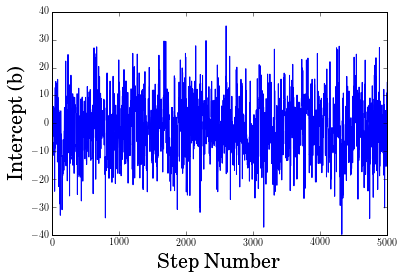

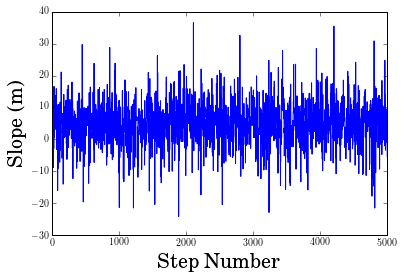

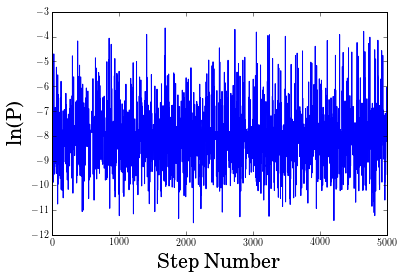

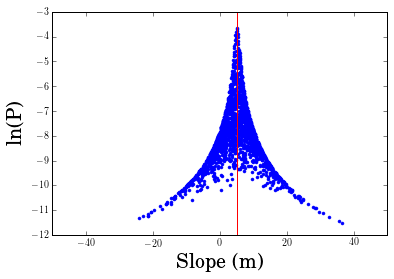

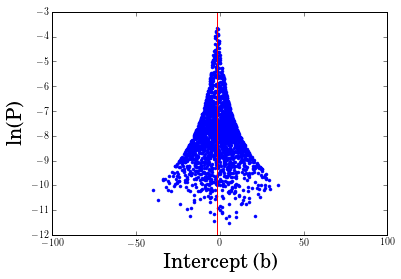

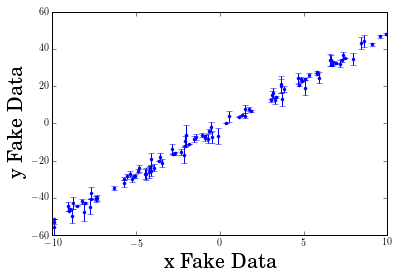

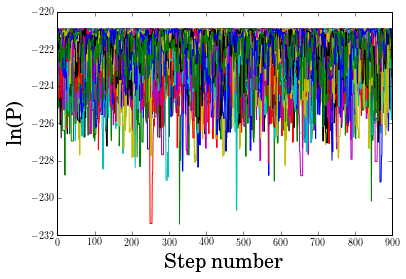

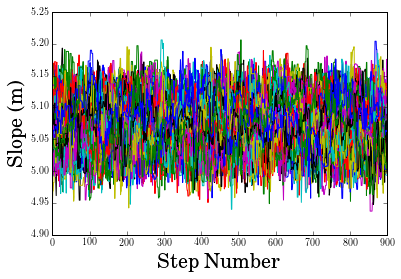

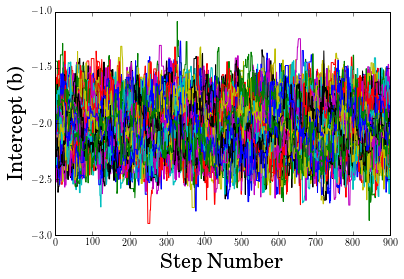

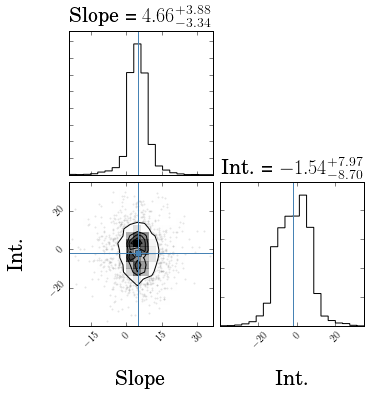

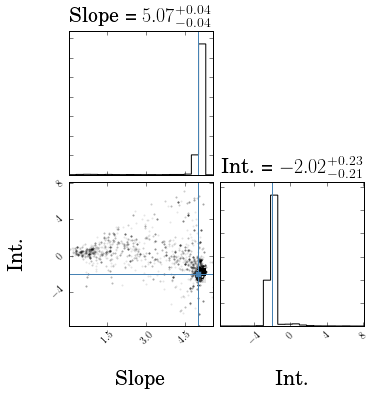

In [156]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import corner
from scipy.stats import norm
import emcee

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
text_size = 20

m = 5.
b = -2.
num_data = 100
mu = 5
steps = 5000

def make_data(m,b,num_data):
    """A Function that creates fake linear data with gaussian sampled errors"""
    x = np.random.uniform(-10,10,num_data)
    error = np.random.normal(loc = 0 , scale = 2. , size = num_data)
    y = m*x+b+error
    return x,y,error

def find_chi(m, b, x, y):
    """A function that finds the square of the difference between an m and b value and the fake generated data."""
    chis = []
    for i in range(len(y)):
        chis.append((((m*x[i]+b)-y[i])**2)/abs(y[i]))
    chi_sum = np.sum(chis)
    return 1/chi_sum

def lnprob(m_b,x,y,sigma):
    """Function to feed to emcee that computes the ln(P) of the posterior, assuming flat priors. It calculates
    the y values from the guessed m and b values an.d compares them to the raw fake data y values, another, more simple
    and straighforward method of determining p(m,b|x,y)
    """
    y_test = m_b[0]*x + m_b[1]
    p = np.sum(np.log(norm.pdf(y, loc = y_test, scale = sigma)))
    return p

def mc_chain(x, y):
    p_list = []
    acceptance_list = []
    m_list =[]
    b_list =[]
    m_1 = 0
    b_1 = 0
    p_1 = find_chi(m_1, b_1,x,y)
    for i in range(steps):
        #pick random m_2 and b_2 value from gaussian centered at previous values
        m_2 = np.random.normal(loc = m_1, scale = 12)
        b_2 = np.random.normal(loc = b_1, scale = 12)
        #find P(x|m,b) for the new m and b values
        p_2 = find_chi(m_2, b_2,x,y)
        r = np.random.rand(1)
        #calculate the acceptance value of the two probabilities
        acceptance = p_2/p_1
        #if acceptance is greater than 1, update m_1 to m_2, b_1 to b_2 and append the m_list, b_list and p_list
        if acceptance > 1.:
            acceptance_list.append(1)
            p_list.append(p_2)
            b_list.append(b_2)
            m_list.append(m_2)
            m_1 = m_2
            b_1 = b_2
        #if acceptance is less than 1, check it against a random float between 0 and 1
        elif acceptance >= r:
            acceptance_list.append(acceptance)
            p_list.append(p_2)
            b_list.append(b_2)
            m_list.append(m_2)
        else:
            acceptance_list.append(acceptance)
            p_list.append(p_1)
            b_list.append(b_1)
            m_list.append(m_1)
    #m_b= np.vstack((np.array(m_list),np.array(b_list)).T
    m_b= np.vstack((m_list,b_list)).T
    return m_b, m_list, b_list, p_list, acceptance_list

x, y, error = make_data(m, b, num_data)
m_b, m_list, b_list, p_list, acceptance_list = mc_chain(x, y)  

print 'the average acceptance rate is ', np.mean(acceptance_list)

#emcee
n_walkers = 100
ndim = 2
initial = [np.random.rand(ndim) for i in range(n_walkers)]
sampler = emcee.EnsembleSampler(n_walkers, ndim, lnprob, args=[x, y, sigma])
sampler.run_mcmc(initial, 1000)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#plot the step number vs. intercept
plt.figure(1)
plt.plot(m_b[:,1])
plt.xlabel(r'Step Number',fontsize=text_size)
plt.ylabel(r'Intercept (b)',fontsize=text_size)
plt.savefig("b_step_%s_data_points.png"% num_data, dpi=300)

#plot step number vs slope
plt.figure(2)
plt.plot(m_b[:,0])
plt.xlabel(r'Step Number',fontsize=text_size)
plt.ylabel(r'Slope (m)',fontsize=text_size)
plt.savefig("m_step_%s_data_points.png"% num_data, dpi=300)

#plot step number vs. ln(p)
plt.figure(3)
plt.plot(np.log(p_list))
plt.xlabel(r'Step Number',fontsize=text_size)
plt.ylabel(r'ln(P)',fontsize=text_size)
plt.savefig("lnp_step_%s_data_points.png"% num_data, dpi=300)

#plot m vs. ln (p)
plt.figure(4)
plt.plot(m_list,np.log(p_list), '.' )
plt.axvline(5. ,color = 'red')
plt.xlim(-50,50)
plt.xlabel(r'Slope (m)',fontsize=text_size)
plt.ylabel(r'ln(P)',fontsize=text_size)
plt.savefig("lnp_m_%s_data_points.png"% num_data, dpi=300)

plt.figure(5)
plt.title('')
plt.plot(b_list,np.log(p_list), '.' )
plt.axvline(-2. ,color = 'red')
plt.xlim(-100,100)
plt.xlabel(r'Intercept (b)',fontsize=text_size)
plt.ylabel(r'ln(P)',fontsize=text_size)
plt.savefig("lnp_b_%s_data_points.png"% num_data, dpi=300)

#plot fake data x vs y with error bars
plt.figure(6)
plt.errorbar(x, y , yerr = error, marker = '.', ls = 'None')
plt.xlabel(r'x Fake Data', fontsize = text_size)
plt.ylabel(r'y Fake Data', fontsize = text_size)
plt.savefig("x_y_%s_fake_data_points.png"% num_data, dpi=300)

#plot ln(P) vs. step number for emcee sampler
plt.figure(7)
[plt.plot(sampler.lnprobability[i,100:]) for i in range(100)]
plt.xlabel(r'Step number', fontsize = text_size)
plt.ylabel(r'ln(P)', fontsize = text_size)
plt.savefig("lnp_step_%s_emcee.png"% num_data, dpi=300)

#m vs. Step Number
plt.figure(8)
[plt.plot(sampler.chain[i,100:,0]) for i in range(100)]
plt.xlabel(r'Step Number', fontsize = text_size)
plt.ylabel(r'Slope (m)', fontsize = text_size)
plt.savefig("m_step_%s_emcee.png"% num_data, dpi=300)


#b vs. step Number, snippet borrowed from lecture
plt.figure(9)
[plt.plot(sampler.chain[i,100:,1]) for i in range(100)]
plt.xlabel(r'Step Number', fontsize = text_size)
plt.ylabel(r'Intercept (b)', fontsize = text_size)
plt.savefig("b_step_%s_emcee.png"% num_data, dpi=300)

plt.figure(10)
corner.corner(m_b, labels = [r'Slope',r'Int.'],show_titles = True,\
              plot_contours = True, truths = [m,b], label_kwargs={"fontsize": 20},title_kwargs={"fontsize": 20})
plt.savefig("corner_%s_data_points_test.png"% num_data, dpi=300)

plt.figure(11)
corner.corner(sampler.flatchain[60000:,:], labels = [r'Slope',r'Int.'], show_titles = True,\
              plot_contours = True, truths = [m,b], label_kwargs={"fontsize": 20},title_kwargs={"fontsize": 20})
plt.savefig("corner_%s_data_points_emcee_test.png"% num_data, dpi=300)


plt.show()

